In [2]:
# Cell 1: Import libraries và setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import json
import re
from collections import Counter
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Setup
load_dotenv()
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [4]:
# Cell 2: Load data from database
def get_db_engine():
    database_url = os.getenv("DATABASE_URL")
    return create_engine(database_url)

# Load movies data
engine = get_db_engine()
query = """
SELECT id, title, overview, release_date, vote_average, vote_count, 
       popularity, movie_cast, keywords, genre_ids
FROM movies 

"""

df = pd.read_sql(query, engine)
print(f"📊 Loaded {len(df)} movies")
print(f"📋 Columns: {list(df.columns)}")
df.head()

📊 Loaded 5631 movies
📋 Columns: ['id', 'title', 'overview', 'release_date', 'vote_average', 'vote_count', 'popularity', 'movie_cast', 'keywords', 'genre_ids']


,id,title,overview,release_date,vote_average,vote_count,popularity,movie_cast,keywords,genre_ids
0,278,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,1994-09-23,8.700,28472,28.0192,"[Tim Robbins, Morgan Freeman, Bob Gunton]","[prison, friendship, police brutality, corrupt...","[18, 80]"
1,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,8.700,21568,31.0320,"[Marlon Brando, Al Pacino, James Caan]","[based on novel or book, loss of loved one, lo...","[18, 80]"
2,240,The Godfather Part II,In the continuing saga of the Corleone crime f...,1974-12-20,8.571,13023,17.9621,"[Al Pacino, Robert Duvall, Diane Keaton]","[new year's eve, new york city, based on novel...","[18, 80]"
3,424,Schindler's List,The true story of how businessman Oskar Schind...,1993-12-15,8.564,16499,14.0382,"[Liam Neeson, Ben Kingsley, Ralph Fiennes]","[factory, hero, nazi, concentration camp, ss (...","[18, 36, 10752]"
4,389,12 Angry Men,The defense and the prosecution have rested an...,1957-04-10,8.549,9209,15.6132,"[Martin Balsam, John Fiedler, Lee J. Cobb]","[death penalty, anonymity, court case, court, ...",[18]


In [5]:
# Cell 3: Basic data exploration
print("=== BASIC DATA INFO ===")
print(df.info())
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())
print("\n=== BASIC STATISTICS ===")
print(df.describe())

=== BASIC DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5631 entries, 0 to 5630
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            5631 non-null   int64  
 1   title         5631 non-null   object 
 2   overview      5631 non-null   object 
 3   release_date  5629 non-null   object 
 4   vote_average  5631 non-null   float64
 5   vote_count    5631 non-null   int64  
 6   popularity    5631 non-null   float64
 7   movie_cast    5456 non-null   object 
 8   keywords      5631 non-null   object 
 9   genre_ids     5631 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 440.1+ KB
None

=== MISSING VALUES ===
id                0
title             0
overview          0
release_date      2
vote_average      0
vote_count        0
popularity        0
movie_cast      175
keywords          0
genre_ids         0
dtype: int64

=== BASIC STATISTICS ===
                 id  

In [8]:
# Cell 4: Explore JSON columns (cast, keywords)
def explore_json_column(df, column_name, sample_size=5):
    print(f"\n=== EXPLORING {column_name.upper()} COLUMN ===")
    
    # Sample data
    samples = df[column_name].dropna().head(sample_size)
    for i, sample in enumerate(samples):
        print(f"\nSample {i+1}:")
        try:
            parsed = json.loads(sample) if isinstance(sample, str) else sample
            print(f"Type: {type(parsed)}")
            print(f"Length: {len(parsed) if isinstance(parsed, (list, dict)) else 'N/A'}")
            print(f"Content: {parsed[:3] if isinstance(parsed, list) else parsed}")
        except:
            print(f"Error parsing: {sample[:100]}...")

explore_json_column(df, 'movie_cast')
explore_json_column(df, 'keywords')


=== EXPLORING MOVIE_CAST COLUMN ===

Sample 1:
Type: <class 'list'>
Length: 3
Content: ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']

Sample 2:
Type: <class 'list'>
Length: 3
Content: ['Marlon Brando', 'Al Pacino', 'James Caan']

Sample 3:
Type: <class 'list'>
Length: 3
Content: ['Al Pacino', 'Robert Duvall', 'Diane Keaton']

Sample 4:
Type: <class 'list'>
Length: 3
Content: ['Liam Neeson', 'Ben Kingsley', 'Ralph Fiennes']

Sample 5:
Type: <class 'list'>
Length: 3
Content: ['Martin Balsam', 'John Fiedler', 'Lee J. Cobb']

=== EXPLORING KEYWORDS COLUMN ===

Sample 1:
Type: <class 'list'>
Length: 18
Content: ['prison', 'friendship', 'police brutality']

Sample 2:
Type: <class 'list'>
Length: 26
Content: ['based on novel or book', 'loss of loved one', 'love at first sight']

Sample 3:
Type: <class 'list'>
Length: 29
Content: ["new year's eve", 'new york city', 'based on novel or book']

Sample 4:
Type: <class 'list'>
Length: 24
Content: ['factory', 'hero', 'nazi']

Sample 5:
Type: <cla

📈 Extracted 16254 cast entries

🎭 TOP 20 ACTORS BY MOVIE COUNT:
actor
Tom Hanks            41
Robert De Niro       37
Brad Pitt            28
Clint Eastwood       28
Denzel Washington    27
Tom Cruise           27
Al Pacino            27
Johnny Depp          27
Mel Gibson           25
Samuel L. Jackson    24
Woody Harrelson      24
Keanu Reeves         24
Jake Gyllenhaal      23
Nicolas Cage         23
Leonardo DiCaprio    23
Matt Damon           23
Mark Ruffalo         23
Russell Crowe        22
Kevin Costner        22
Jackie Chan          22
Name: count, dtype: int64


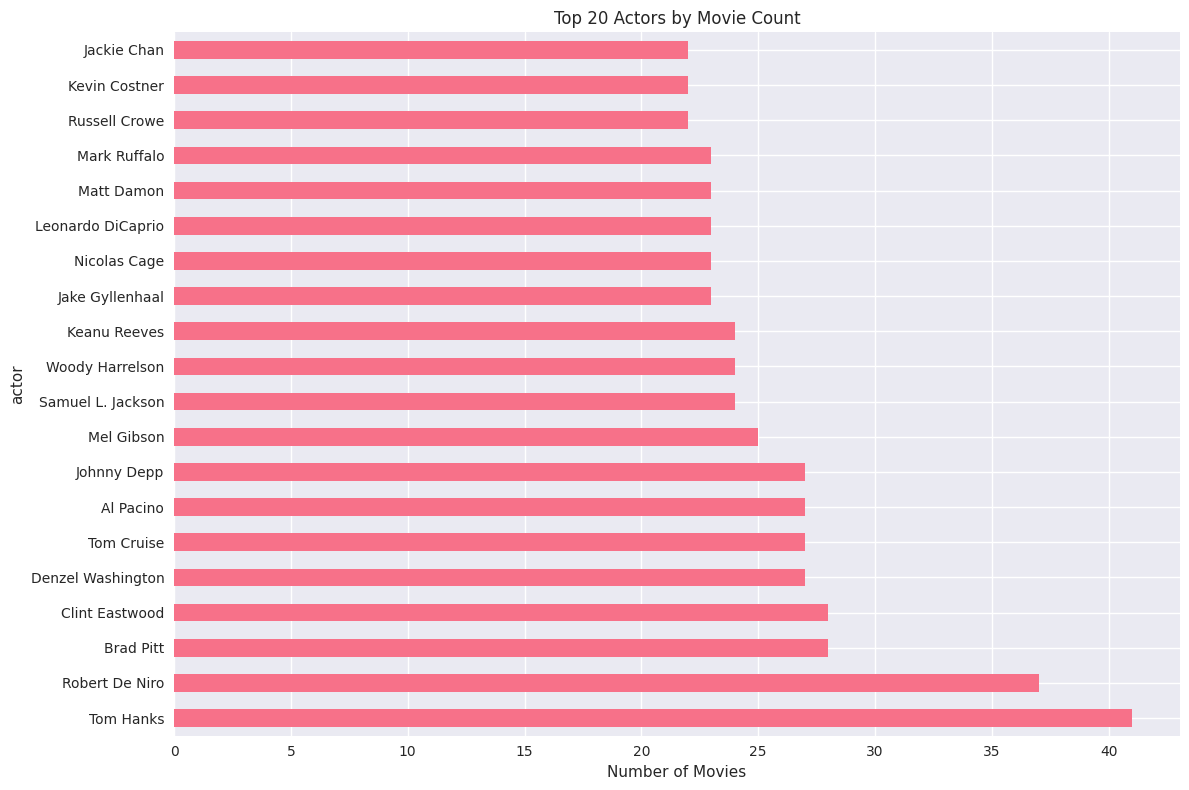

In [11]:
# Cell 5: Parse and analyze cast data
def parse_cast_data(df):
    """Parse cast data and extract insights"""
    cast_data = []
    
    for idx, cast_json in df['movie_cast'].dropna().items():
        try:
            if isinstance(cast_json, str):
                cast_list = json.loads(cast_json)
            else:
                cast_list = cast_json
                
            if isinstance(cast_list, list):
                movie_title = df.loc[idx, 'title']
                for actor in cast_list[:5]:  # Top 5 actors
                    if isinstance(actor, str):
                        cast_data.append({
                            'movie_id': df.loc[idx, 'id'],
                            'movie_title': movie_title,
                            'actor': actor
                        })
        except:
            continue
    
    return pd.DataFrame(cast_data)

cast_df = parse_cast_data(df)
print(f"📈 Extracted {len(cast_df)} cast entries")

# Top actors by movie count
top_actors = cast_df['actor'].value_counts().head(20)
print("\n🎭 TOP 20 ACTORS BY MOVIE COUNT:")
print(top_actors)

# Visualization
plt.figure(figsize=(12, 8))
top_actors.plot(kind='barh')
plt.title('Top 20 Actors by Movie Count')
plt.xlabel('Number of Movies')
plt.tight_layout()
plt.show()

📈 Extracted 67768 keyword entries

🏷️ TOP 30 KEYWORDS:
keyword
based on novel or book       800
based on true story          362
murder                       323
woman director               272
new york city                254
biography                    245
duringcreditsstinger         244
friendship                   223
sequel                       209
black and white              200
aftercreditsstinger          190
parent child relationship    181
revenge                      178
love                         178
anime                        175
based on comic               168
musical                      167
superhero                    158
villain                      157
coming of age                156
amused                       150
lgbt                         148
world war ii                 145
loss of loved one            138
london, england              137
christmas                    136
sibling relationship         136
paris, france                134
los angeles, 

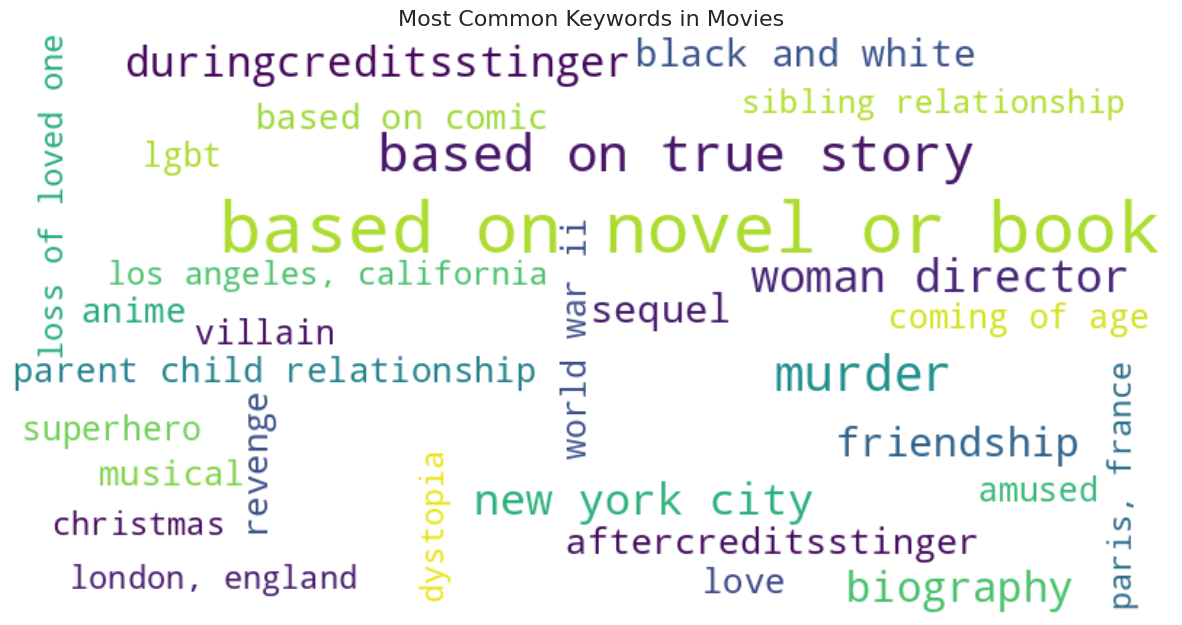

In [12]:
# Cell 6: Parse and analyze keywords data
def parse_keywords_data(df):
    """Parse keywords data and extract insights"""
    keywords_data = []
    
    for idx, keywords_json in df['keywords'].dropna().items():
        try:
            if isinstance(keywords_json, str):
                keywords_list = json.loads(keywords_json)
            else:
                keywords_list = keywords_json
                
            if isinstance(keywords_list, list):
                movie_title = df.loc[idx, 'title']
                for keyword in keywords_list:
                    if isinstance(keyword, str):
                        keywords_data.append({
                            'movie_id': df.loc[idx, 'id'],
                            'movie_title': movie_title,
                            'keyword': keyword
                        })
        except:
            continue
    
    return pd.DataFrame(keywords_data)

keywords_df = parse_keywords_data(df)
print(f"📈 Extracted {len(keywords_df)} keyword entries")

# Top keywords
top_keywords = keywords_df['keyword'].value_counts().head(30)
print("\n🏷️ TOP 30 KEYWORDS:")
print(top_keywords)

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_keywords.to_dict())
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Keywords in Movies', fontsize=16)
plt.show()

=== OVERVIEW TEXT ANALYSIS ===
Total characters: 1,484,106
Average overview length: 262.6 characters
Average word count: 44.7 words


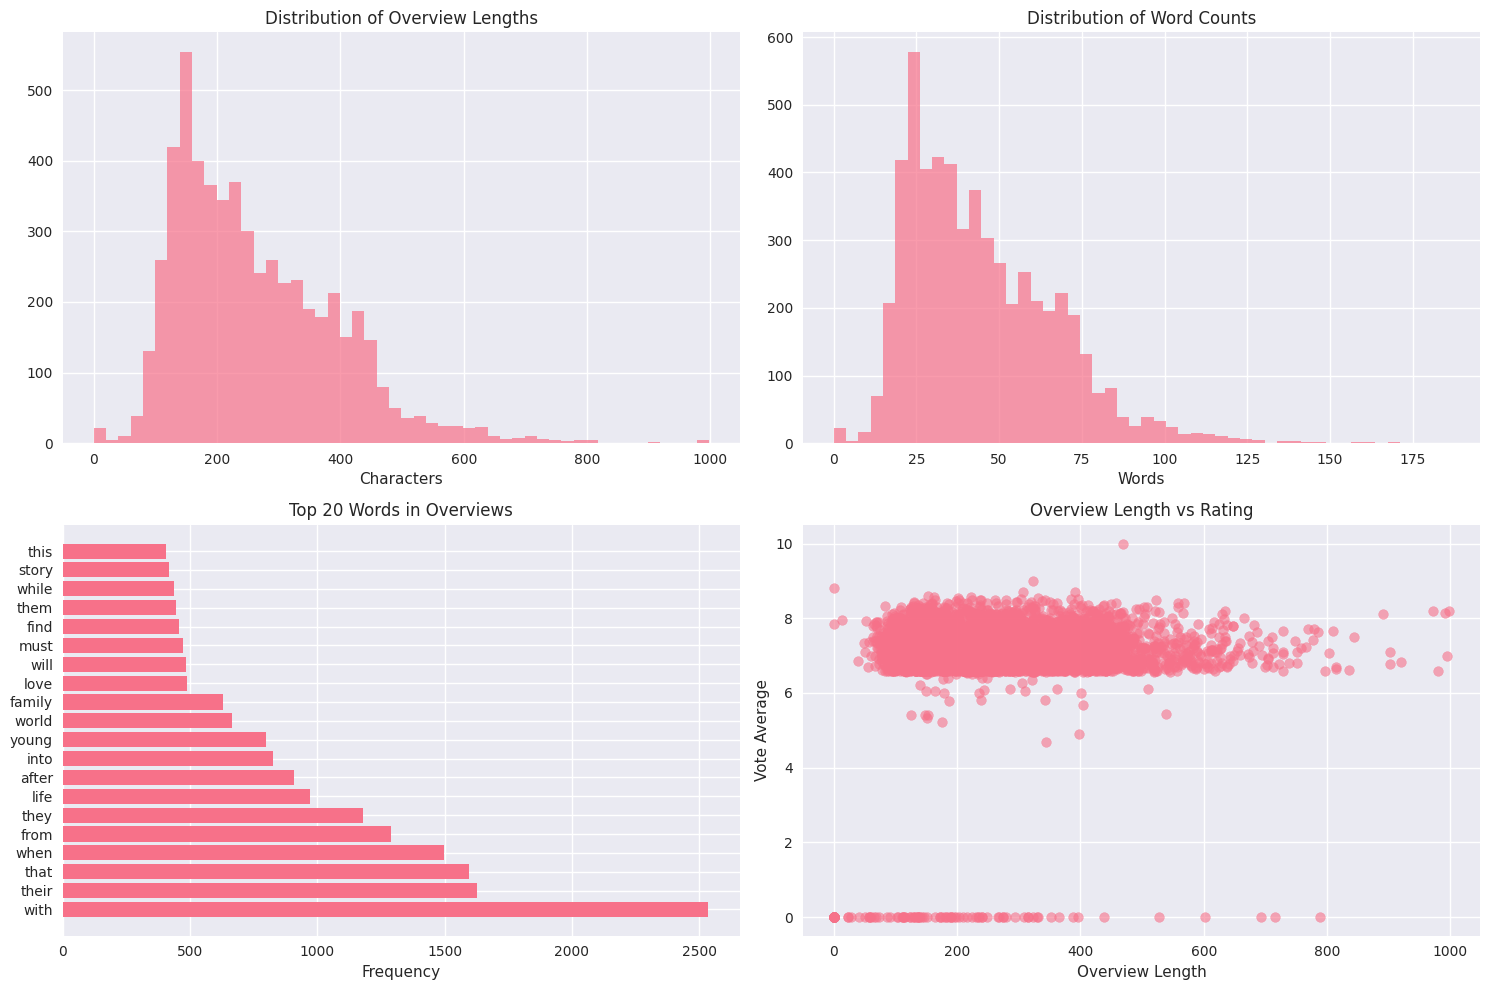

In [13]:
# Cell 7: Advanced text analysis of overview
def analyze_overview_text(df):
    """Analyze overview text patterns"""
    # Combine all overviews
    all_overviews = ' '.join(df['overview'].dropna().astype(str))
    
    # Basic stats
    overview_lengths = df['overview'].dropna().str.len()
    word_counts = df['overview'].dropna().str.split().str.len()
    
    print("=== OVERVIEW TEXT ANALYSIS ===")
    print(f"Total characters: {len(all_overviews):,}")
    print(f"Average overview length: {overview_lengths.mean():.1f} characters")
    print(f"Average word count: {word_counts.mean():.1f} words")
    
    # Distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Overview length distribution
    axes[0,0].hist(overview_lengths, bins=50, alpha=0.7)
    axes[0,0].set_title('Distribution of Overview Lengths')
    axes[0,0].set_xlabel('Characters')
    
    # Word count distribution
    axes[0,1].hist(word_counts, bins=50, alpha=0.7)
    axes[0,1].set_title('Distribution of Word Counts')
    axes[0,1].set_xlabel('Words')
    
    # Top words in overviews
    words = re.findall(r'\b[a-zA-Z]{4,}\b', all_overviews.lower())
    word_freq = Counter(words)
    top_words = dict(word_freq.most_common(20))
    
    axes[1,0].barh(list(top_words.keys()), list(top_words.values()))
    axes[1,0].set_title('Top 20 Words in Overviews')
    axes[1,0].set_xlabel('Frequency')
    
    # Overview length vs rating
    df_clean = df.dropna(subset=['overview', 'vote_average'])
    overview_lens = df_clean['overview'].str.len()
    axes[1,1].scatter(overview_lens, df_clean['vote_average'], alpha=0.6)
    axes[1,1].set_title('Overview Length vs Rating')
    axes[1,1].set_xlabel('Overview Length')
    axes[1,1].set_ylabel('Vote Average')
    
    plt.tight_layout()
    plt.show()
    
    return word_freq

word_freq = analyze_overview_text(df)

In [41]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Cell 8: Feature Engineering - Create comprehensive tags

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

def create_advanced_features(df):
    """Create advanced features for recommendation system"""
    
    def safe_json_parse(json_str):
        try:
            if pd.isna(json_str) or json_str == '':
                return []
            return json.loads(json_str) if isinstance(json_str, str) else json_str
        except:
            return []
    
    def clean_text(text):
        """Advanced text cleaning with stopwords removal and lemmatization"""
        if pd.isna(text) or text == '':
            return ""
        
        # Convert to lowercase (already implemented)
        text = str(text).lower()
        
        # Remove special characters, keep alphanumeric and spaces (already implemented)
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        
        # Remove extra spaces (already implemented)
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenize text
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def extract_names(json_list):
        """Extract names from cast/keywords list"""
        if not isinstance(json_list, list):
            return []
        
        names = []
        for item in json_list:
            if isinstance(item, str):
                # Remove spaces to treat as single entity
                clean_name = re.sub(r'[^a-zA-Z0-9]', '', item.strip())
                if clean_name:
                    names.append(clean_name.lower())
        return names
    
    # Parse JSON columns
    df['cast_list'] = df['movie_cast'].apply(safe_json_parse)
    df['keywords_list'] = df['keywords'].apply(safe_json_parse)
    
    # Extract features
    df['cast_names'] = df['cast_list'].apply(lambda x: extract_names(x[:5]))  # Top 5 cast
    df['keyword_names'] = df['keywords_list'].apply(extract_names)
    df['overview_clean'] = df['overview'].apply(clean_text)
    
    # Create different types of tags
    def create_content_tags(row):
        """Create content-based tags with different strategies"""
        tags = {}
        
        # Strategy 1: Equal weight
        equal_parts = []
        if row['overview_clean']:
            equal_parts.append(row['overview_clean'])
        if row['cast_names']:
            equal_parts.append(' '.join(row['cast_names']))
        if row['keyword_names']:
            equal_parts.append(' '.join(row['keyword_names']))
        tags['equal_weight'] = ' '.join(equal_parts)
        
        # Strategy 2: Overview-heavy (3:1:1 ratio)
        overview_heavy = []
        if row['overview_clean']:
            overview_heavy.extend([row['overview_clean']] * 3)
        if row['cast_names']:
            overview_heavy.append(' '.join(row['cast_names']))
        if row['keyword_names']:
            overview_heavy.append(' '.join(row['keyword_names']))
        tags['overview_heavy'] = ' '.join(overview_heavy)
        
        # Strategy 3: Metadata-heavy (1:2:2 ratio)
        metadata_heavy = []
        if row['overview_clean']:
            metadata_heavy.append(row['overview_clean'])
        if row['cast_names']:
            metadata_heavy.extend([' '.join(row['cast_names'])] * 2)
        if row['keyword_names']:
            metadata_heavy.extend([' '.join(row['keyword_names'])] * 2)
        tags['metadata_heavy'] = ' '.join(metadata_heavy)
        
        # Strategy 4: Keywords-focused (1:1:3 ratio)
        keywords_heavy = []
        if row['overview_clean']:
            keywords_heavy.append(row['overview_clean'])
        if row['cast_names']:
            keywords_heavy.append(' '.join(row['cast_names']))
        if row['keyword_names']:
            keywords_heavy.extend([' '.join(row['keyword_names'])] * 3)
        tags['keywords_heavy'] = ' '.join(keywords_heavy)
        
        return tags
    
    # Apply feature creation
    print("🔧 Creating advanced features...")
    tag_results = df.apply(create_content_tags, axis=1)
    
    # Extract different tag strategies
    for strategy in ['equal_weight', 'overview_heavy', 'metadata_heavy', 'keywords_heavy']:
        df[f'tags_{strategy}'] = tag_results.apply(lambda x: x[strategy])
    
    # FIXED: Add numerical features - use .apply(len) for lists, not .str.len()
    df['has_overview'] = df['overview_clean'].str.len() > 0  # This is correct (string)
    df['has_cast'] = df['cast_names'].apply(len) > 0         # FIXED: use .apply(len) for lists
    df['has_keywords'] = df['keyword_names'].apply(len) > 0  # FIXED: use .apply(len) for lists
    df['cast_count'] = df['cast_names'].apply(len)           # FIXED: use .apply(len) for lists
    df['keyword_count'] = df['keyword_names'].apply(len)     # FIXED: use .apply(len) for lists
    df['overview_length'] = df['overview_clean'].str.len()   # This is correct (string)
    
    return df

# Apply advanced feature engineering
df_features = create_advanced_features(df.copy())

print("✅ Advanced features created!")
print("\n📊 New columns:", [col for col in df_features.columns if col not in df.columns])

[nltk_data] Downloading package wordnet to /home/hoang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


🔧 Creating advanced features...
✅ Advanced features created!

📊 New columns: ['cast_list', 'keywords_list', 'cast_names', 'keyword_names', 'overview_clean', 'tags_equal_weight', 'tags_overview_heavy', 'tags_metadata_heavy', 'tags_keywords_heavy', 'has_overview', 'has_cast', 'has_keywords', 'cast_count', 'keyword_count', 'overview_length']


In [52]:
df_features[['cast_list','cast_names']].head()

,cast_list,cast_names
0,[],[]
1,[],[]
2,[],[]
3,[],[]
4,[],[]


In [48]:
df_features.head()

,id,title,overview,release_date,vote_average,vote_count,popularity,movie_cast,keywords,genre_ids,...,tags_equal_weight,tags_overview_heavy,tags_metadata_heavy,tags_keywords_heavy,has_overview,has_cast,has_keywords,cast_count,keyword_count,overview_length
0,278,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,1994-09-23,8.700,28472,28.0192,"[Tim Robbins, Morgan Freeman, Bob Gunton]","[prison, friendship, police brutality, corrupt...","[18, 80]",...,imprisoned 1940s double murder wife lover upst...,imprisoned 1940s double murder wife lover upst...,imprisoned 1940s double murder wife lover upst...,imprisoned 1940s double murder wife lover upst...,True,False,False,0,0,263
1,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,8.700,21568,31.0320,"[Marlon Brando, Al Pacino, James Caan]","[based on novel or book, loss of loved one, lo...","[18, 80]",...,spanning year 1945 1955 chronicle fictional it...,spanning year 1945 1955 chronicle fictional it...,spanning year 1945 1955 chronicle fictional it...,spanning year 1945 1955 chronicle fictional it...,True,False,False,0,0,241
2,240,The Godfather Part II,In the continuing saga of the Corleone crime f...,1974-12-20,8.571,13023,17.9621,"[Al Pacino, Robert Duvall, Diane Keaton]","[new year's eve, new york city, based on novel...","[18, 80]",...,continuing saga corleone crime family young vi...,continuing saga corleone crime family young vi...,continuing saga corleone crime family young vi...,continuing saga corleone crime family young vi...,True,False,False,0,0,162
3,424,Schindler's List,The true story of how businessman Oskar Schind...,1993-12-15,8.564,16499,14.0382,"[Liam Neeson, Ben Kingsley, Ralph Fiennes]","[factory, hero, nazi, concentration camp, ss (...","[18, 36, 10752]",...,true story businessman oskar schindler saved t...,true story businessman oskar schindler saved t...,true story businessman oskar schindler saved t...,true story businessman oskar schindler saved t...,True,False,False,0,0,101
4,389,12 Angry Men,The defense and the prosecution have rested an...,1957-04-10,8.549,9209,15.6132,"[Martin Balsam, John Fiedler, Lee J. Cobb]","[death penalty, anonymity, court case, court, ...",[18],...,defense prosecution rested jury filing jury ro...,defense prosecution rested jury filing jury ro...,defense prosecution rested jury filing jury ro...,defense prosecution rested jury filing jury ro...,True,False,False,0,0,200


In [53]:
# Debug để tìm ra vấn đề parsing
import json

print("=== DEBUGGING PARSING ISSUE ===")

# Kiểm tra dữ liệu raw
sample_idx = 0
print(f"\n1. RAW DATA:")
print(f"movie_cast: {repr(df.iloc[sample_idx]['movie_cast'])}")
print(f"Type: {type(df.iloc[sample_idx]['movie_cast'])}")
print(f"keywords: {repr(df.iloc[sample_idx]['keywords'])}")
print(f"Type: {type(df.iloc[sample_idx]['keywords'])}")

# Test safe_json_parse function
def debug_safe_json_parse(json_str):
    print(f"\n2. TESTING safe_json_parse:")
    print(f"Input: {repr(json_str)}")
    print(f"Input type: {type(json_str)}")
    print(f"pd.isna check: {pd.isna(json_str)}")
    print(f"Empty string check: {json_str == ''}")
    
    try:
        if pd.isna(json_str) or json_str == '':
            print("→ Returning [] (empty case)")
            return []
        
        print(f"Is string: {isinstance(json_str, str)}")
        
        if isinstance(json_str, str):
            result = json.loads(json_str)
            print(f"→ JSON parsed successfully: {result}")
            print(f"→ Type: {type(result)}")
            return result
        else:
            print(f"→ Not string, returning as-is: {json_str}")
            return json_str
    except Exception as e:
        print(f"→ Error: {e}")
        return []

# Test với movie_cast
cast_result = debug_safe_json_parse(df.iloc[sample_idx]['movie_cast'])
print(f"\n3. CAST RESULT: {cast_result}")

# Test với keywords  
keywords_result = debug_safe_json_parse(df.iloc[sample_idx]['keywords'])
print(f"\n4. KEYWORDS RESULT: {keywords_result}")

# Test extract_names function
def debug_extract_names(json_list):
    print(f"\n5. TESTING extract_names:")
    print(f"Input: {json_list}")
    print(f"Input type: {type(json_list)}")
    print(f"Is list: {isinstance(json_list, list)}")
    
    if not isinstance(json_list, list):
        print("→ Not a list, returning []")
        return []
    
    names = []
    for i, item in enumerate(json_list):
        print(f"  Item {i}: {repr(item)} (type: {type(item)})")
        if isinstance(item, str):
            clean_name = re.sub(r'[^a-zA-Z0-9]', '', item.strip())
            if clean_name:
                names.append(clean_name.lower())
                print(f"    → Added: {clean_name.lower()}")
        else:
            print(f"    → Skipped (not string)")
    
    print(f"→ Final names: {names}")
    return names

# Test extract_names với kết quả parsed
cast_names = debug_extract_names(cast_result)
keywords_names = debug_extract_names(keywords_result)

print(f"\n6. FINAL RESULTS:")
print(f"Cast names: {cast_names}")
print(f"Keywords names: {keywords_names}")

# Kiểm tra thêm vài rows khác
print(f"\n7. CHECKING MORE ROWS:")
for i in range(min(3, len(df))):
    print(f"\nRow {i}:")
    print(f"  movie_cast: {repr(df.iloc[i]['movie_cast'])}")
    print(f"  keywords: {repr(df.iloc[i]['keywords'])}")

=== DEBUGGING PARSING ISSUE ===

1. RAW DATA:
movie_cast: ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']
Type: <class 'list'>
keywords: ['prison', 'friendship', 'police brutality', 'corruption', 'based on novel or book', 'freedom', 'hope', 'prison cell', 'delinquent', 'redemption', 'parole board', 'prison escape', 'wrongful imprisonment', 'interracial friendship', 'framed for murder', '1940s', 'voiceover', 'admiring']
Type: <class 'list'>

2. TESTING safe_json_parse:
Input: ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']
Input type: <class 'list'>
pd.isna check: [False False False]
Empty string check: False
→ Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

3. CAST RESULT: []

2. TESTING safe_json_parse:
Input: ['prison', 'friendship', 'police brutality', 'corruption', 'based on novel or book', 'freedom', 'hope', 'prison cell', 'delinquent', 'redemption', 'parole board', 'prison escape', 'wrongful imprisonment', 'interracial friendshi

In [54]:
import ast
import json
import re

def create_advanced_features(df):
    """Create advanced features for recommendation system"""
    
    def robust_parse(data):
        """Robust parsing that handles multiple data formats"""
        print(f"Parsing: {repr(data)} (type: {type(data)})")
        
        # Already a list
        if isinstance(data, list):
            print("→ Already a list")
            return data
        
        # NaN or empty
        if pd.isna(data) or data == '' or data is None:
            print("→ Empty/NaN, returning []")
            return []
        
        # Convert to string first
        data_str = str(data).strip()
        
        # Empty string
        if not data_str:
            print("→ Empty string, returning []")
            return []
        
        # Try JSON first (double quotes)
        try:
            result = json.loads(data_str)
            print(f"→ JSON parsed: {result}")
            return result if isinstance(result, list) else []
        except:
            pass
        
        # Try ast.literal_eval (handles Python literals with single quotes)
        try:
            result = ast.literal_eval(data_str)
            print(f"→ AST parsed: {result}")
            return result if isinstance(result, list) else []
        except:
            pass
        
        # Try manual parsing for simple cases like "['item1', 'item2']"
        try:
            # Remove outer brackets and split by comma
            if data_str.startswith('[') and data_str.endswith(']'):
                inner = data_str[1:-1].strip()
                if not inner:
                    return []
                
                # Split by comma and clean each item
                items = []
                for item in inner.split(','):
                    item = item.strip().strip("'\"")
                    if item:
                        items.append(item)
                print(f"→ Manual parsed: {items}")
                return items
        except:
            pass
        
        print(f"→ Failed to parse, returning []")
        return []
    
    def extract_names_robust(data_list):
        """Extract names from various data formats"""
        if not isinstance(data_list, list):
            return []
        
        names = []
        for item in data_list:
            name = None
            
            # Dictionary (common in JSON APIs)
            if isinstance(item, dict):
                # Try various common keys
                name = (item.get('name') or 
                       item.get('Name') or 
                       item.get('actor_name') or 
                       item.get('character') or
                       item.get('keyword'))
            
            # Already a string
            elif isinstance(item, str):
                name = item
            
            # Add clean name
            if name:
                clean_name = re.sub(r'[^a-zA-Z0-9]', '', str(name).strip())
                if clean_name:
                    names.append(clean_name.lower())
        
        return names
    
    def clean_text(text):
        """Advanced text cleaning with stopwords removal and lemmatization"""
        if pd.isna(text) or text == '':
            return ""
        
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenize text
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    # Parse columns with robust parsing
    print("🔧 Parsing movie_cast...")
    df['cast_list'] = df['movie_cast'].apply(robust_parse)
    
    print("🔧 Parsing keywords...")
    df['keywords_list'] = df['keywords'].apply(robust_parse)
    
    # Debug: Show sample parsed data
    print("\n📊 Sample parsed data:")
    for i in range(min(3, len(df))):
        print(f"Row {i}:")
        print(f"  Cast list: {df.iloc[i]['cast_list']}")
        print(f"  Keywords list: {df.iloc[i]['keywords_list']}")
    
    # Extract names
    print("\n🔧 Extracting names...")
    df['cast_names'] = df['cast_list'].apply(lambda x: extract_names_robust(x[:5]))
    df['keyword_names'] = df['keywords_list'].apply(extract_names_robust)
    df['overview_clean'] = df['overview'].apply(clean_text)
    
    # Debug: Show extracted names
    print("\n📊 Sample extracted names:")
    for i in range(min(3, len(df))):
        print(f"Row {i}:")
        print(f"  Cast names: {df.iloc[i]['cast_names']}")
        print(f"  Keyword names: {df.iloc[i]['keyword_names']}")
    
    # Create tags (keeping original logic)
    def create_content_tags(row):
        tags = {}
        
        # Strategy 1: Equal weight
        equal_parts = []
        if row['overview_clean']:
            equal_parts.append(row['overview_clean'])
        if row['cast_names']:
            equal_parts.append(' '.join(row['cast_names']))
        if row['keyword_names']:
            equal_parts.append(' '.join(row['keyword_names']))
        tags['equal_weight'] = ' '.join(equal_parts)
        
        # Strategy 2: Overview-heavy (3:1:1 ratio)
        overview_heavy = []
        if row['overview_clean']:
            overview_heavy.extend([row['overview_clean']] * 3)
        if row['cast_names']:
            overview_heavy.append(' '.join(row['cast_names']))
        if row['keyword_names']:
            overview_heavy.append(' '.join(row['keyword_names']))
        tags['overview_heavy'] = ' '.join(overview_heavy)
        
        # Strategy 3: Metadata-heavy (1:2:2 ratio)
        metadata_heavy = []
        if row['overview_clean']:
            metadata_heavy.append(row['overview_clean'])
        if row['cast_names']:
            metadata_heavy.extend([' '.join(row['cast_names'])] * 2)
        if row['keyword_names']:
            metadata_heavy.extend([' '.join(row['keyword_names'])] * 2)
        tags['metadata_heavy'] = ' '.join(metadata_heavy)
        
        # Strategy 4: Keywords-focused (1:1:3 ratio)
        keywords_heavy = []
        if row['overview_clean']:
            keywords_heavy.append(row['overview_clean'])
        if row['cast_names']:
            keywords_heavy.append(' '.join(row['cast_names']))
        if row['keyword_names']:
            keywords_heavy.extend([' '.join(row['keyword_names'])] * 3)
        tags['keywords_heavy'] = ' '.join(keywords_heavy)
        
        return tags
    
    # Apply feature creation
    print("\n🔧 Creating tags...")
    tag_results = df.apply(create_content_tags, axis=1)
    
    # Extract different tag strategies
    for strategy in ['equal_weight', 'overview_heavy', 'metadata_heavy', 'keywords_heavy']:
        df[f'tags_{strategy}'] = tag_results.apply(lambda x: x[strategy])
    
    # Add numerical features
    print("\n🔧 Creating numerical features...")
    df['has_overview'] = df['overview_clean'].str.len() > 0
    df['has_cast'] = df['cast_names'].apply(len) > 0
    df['has_keywords'] = df['keyword_names'].apply(len) > 0
    df['cast_count'] = df['cast_names'].apply(len)
    df['keyword_count'] = df['keyword_names'].apply(len)
    df['overview_length'] = df['overview_clean'].str.len()
    
    # Final verification
    print("\n🔍 FINAL VERIFICATION:")
    sample_idx = 0
    if len(df) > 0:
        print(f"Row {sample_idx}:")
        print(f"  has_cast: {df.iloc[sample_idx]['has_cast']}")
        print(f"  cast_count: {df.iloc[sample_idx]['cast_count']}")
        print(f"  has_keywords: {df.iloc[sample_idx]['has_keywords']}")
        print(f"  keyword_count: {df.iloc[sample_idx]['keyword_count']}")
    
    return df

# Apply the robust feature engineering
df_features = create_advanced_features(df.copy())

print("\n✅ Advanced features created!")
print(f"📊 Final shape: {df_features.shape}")
print(f"📊 New columns: {[col for col in df_features.columns if col not in df.columns]}")

# Show verification table
print("\n🔍 VERIFICATION TABLE:")
verification_cols = ['title', 'has_cast', 'cast_count', 'has_keywords', 'keyword_count']
print(df_features[verification_cols].head())

🔧 Parsing movie_cast...
Parsing: ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'] (type: <class 'list'>)
→ Already a list
Parsing: ['Marlon Brando', 'Al Pacino', 'James Caan'] (type: <class 'list'>)
→ Already a list
Parsing: ['Al Pacino', 'Robert Duvall', 'Diane Keaton'] (type: <class 'list'>)
→ Already a list
Parsing: ['Liam Neeson', 'Ben Kingsley', 'Ralph Fiennes'] (type: <class 'list'>)
→ Already a list
Parsing: ['Martin Balsam', 'John Fiedler', 'Lee J. Cobb'] (type: <class 'list'>)
→ Already a list
Parsing: ['Rumi Hiiragi', 'Miyu Irino', 'Mari Natsuki'] (type: <class 'list'>)
→ Already a list
Parsing: ['Christian Bale', 'Heath Ledger', 'Aaron Eckhart'] (type: <class 'list'>)
→ Already a list
Parsing: ['Kajol', 'Shah Rukh Khan', 'Amrish Puri'] (type: <class 'list'>)
→ Already a list
Parsing: ['Sul Kyung-gu', 'Uhm Ji-won', 'Lee Re'] (type: <class 'list'>)
→ Already a list
Parsing: ['Tom Hanks', 'David Morse', 'Bonnie Hunt'] (type: <class 'list'>)
→ Already a list
Parsing: ['Song Kang-

📊 TAGGING STRATEGIES COMPARISON:
                mean_length  median_length  std_length  empty_count
equal_weight         353.15          340.0      133.30         14.0
overview_heavy       714.27          667.0      287.81         14.0
metadata_heavy       526.74          503.0      212.65         14.0
keywords_heavy       624.97          587.0      296.69         14.0


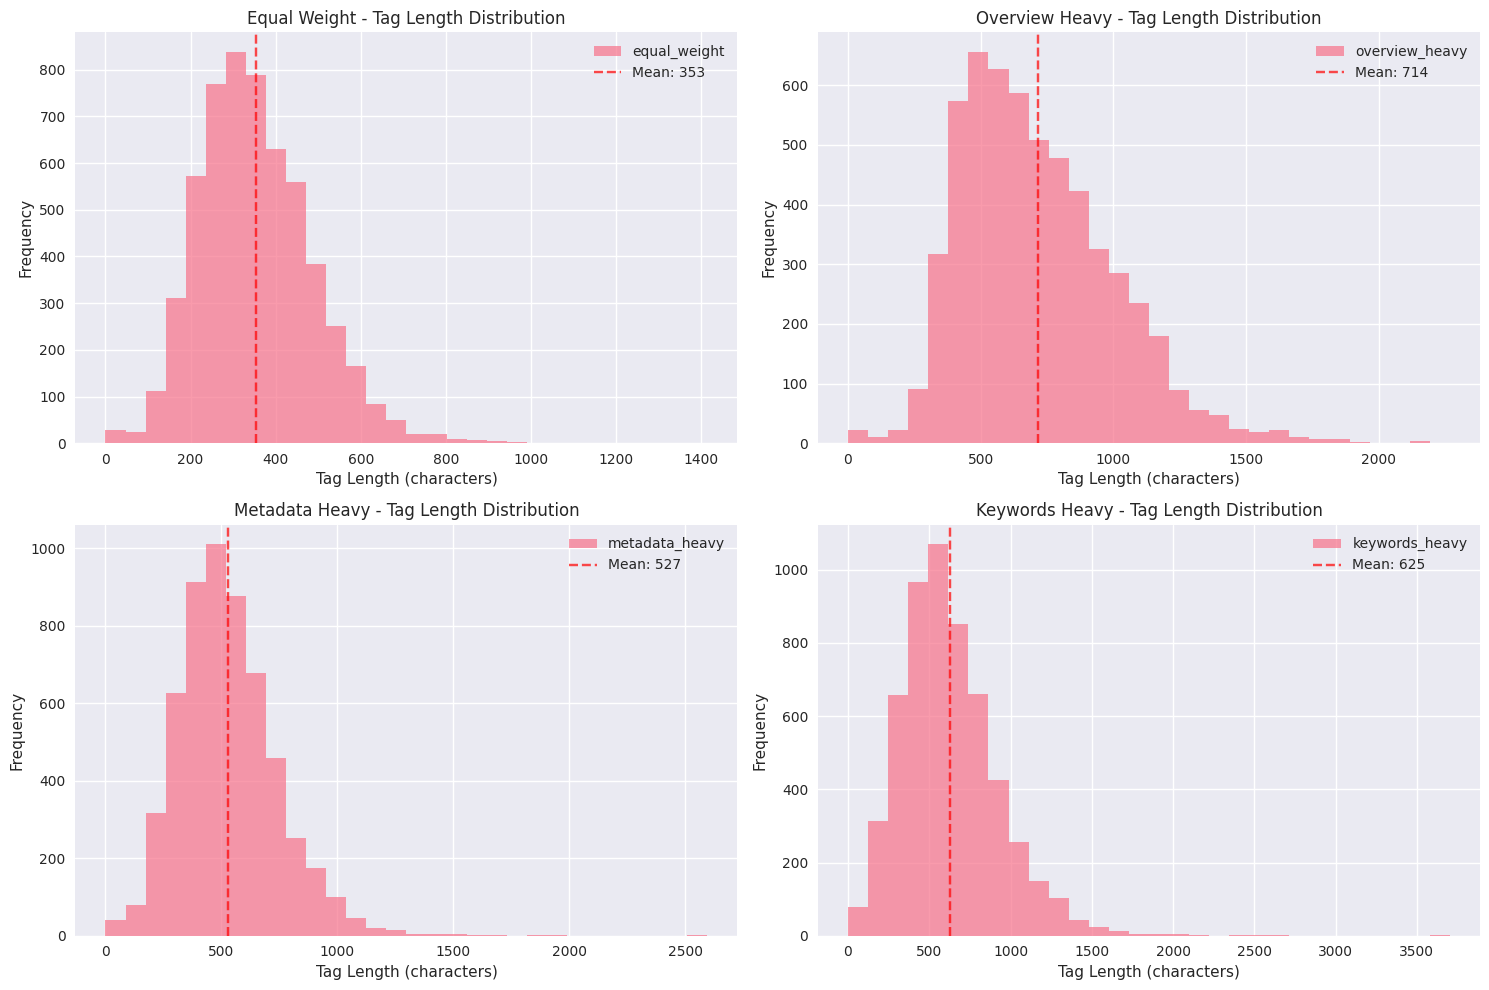


📝 EXAMPLE TAGS FOR SAME MOVIE:
Movie: The Shawshank Redemption
--------------------------------------------------

EQUAL_WEIGHT:
Length: 517 chars
Preview: imprisoned 1940s double murder wife lover upstanding banker andy dufresne begin new life shawshank prison put accounting skill work amoral warden long stretch prison dufresne come admired inmate inclu...

OVERVIEW_HEAVY:
Length: 1045 chars
Preview: imprisoned 1940s double murder wife lover upstanding banker andy dufresne begin new life shawshank prison put accounting skill work amoral warden long stretch prison dufresne come admired inmate inclu...

METADATA_HEAVY:
Length: 771 chars
Preview: imprisoned 1940s double murder wife lover upstanding banker andy dufresne begin new life shawshank prison put accounting skill work amoral warden long stretch prison dufresne come admired inmate inclu...

KEYWORDS_HEAVY:
Length: 955 chars
Preview: imprisoned 1940s double murder wife lover upstanding banker andy dufresne begin new life shawshank

In [55]:
# Cell 9: Compare different tagging strategies
def compare_tagging_strategies(df_features):
    """Compare different tagging strategies"""
    
    strategies = ['equal_weight', 'overview_heavy', 'metadata_heavy', 'keywords_heavy']
    
    # Calculate tag lengths for each strategy
    tag_stats = {}
    for strategy in strategies:
        col_name = f'tags_{strategy}'
        lengths = df_features[col_name].str.len()
        tag_stats[strategy] = {
            'mean_length': lengths.mean(),
            'median_length': lengths.median(),
            'std_length': lengths.std(),
            'empty_count': (lengths == 0).sum()
        }
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame(tag_stats).T
    print("📊 TAGGING STRATEGIES COMPARISON:")
    print(comparison_df.round(2))
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Distribution of tag lengths
    for i, strategy in enumerate(strategies, 1):
        plt.subplot(2, 2, i)
        lengths = df_features[f'tags_{strategy}'].str.len()
        plt.hist(lengths, bins=30, alpha=0.7, label=strategy)
        plt.title(f'{strategy.replace("_", " ").title()} - Tag Length Distribution')
        plt.xlabel('Tag Length (characters)')
        plt.ylabel('Frequency')
        plt.axvline(lengths.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {lengths.mean():.0f}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show examples
    print("\n📝 EXAMPLE TAGS FOR SAME MOVIE:")
    sample_movie = df_features.iloc[0]
    print(f"Movie: {sample_movie['title']}")
    print("-" * 50)
    
    for strategy in strategies:
        tags = sample_movie[f'tags_{strategy}']
        print(f"\n{strategy.upper()}:")
        print(f"Length: {len(tags)} chars")
        print(f"Preview: {tags[:200]}...")

compare_tagging_strategies(df_features)

📈 FEATURE COVERAGE:
has_overview: 99.6%
has_cast: 96.6%
has_keywords: 96.0%


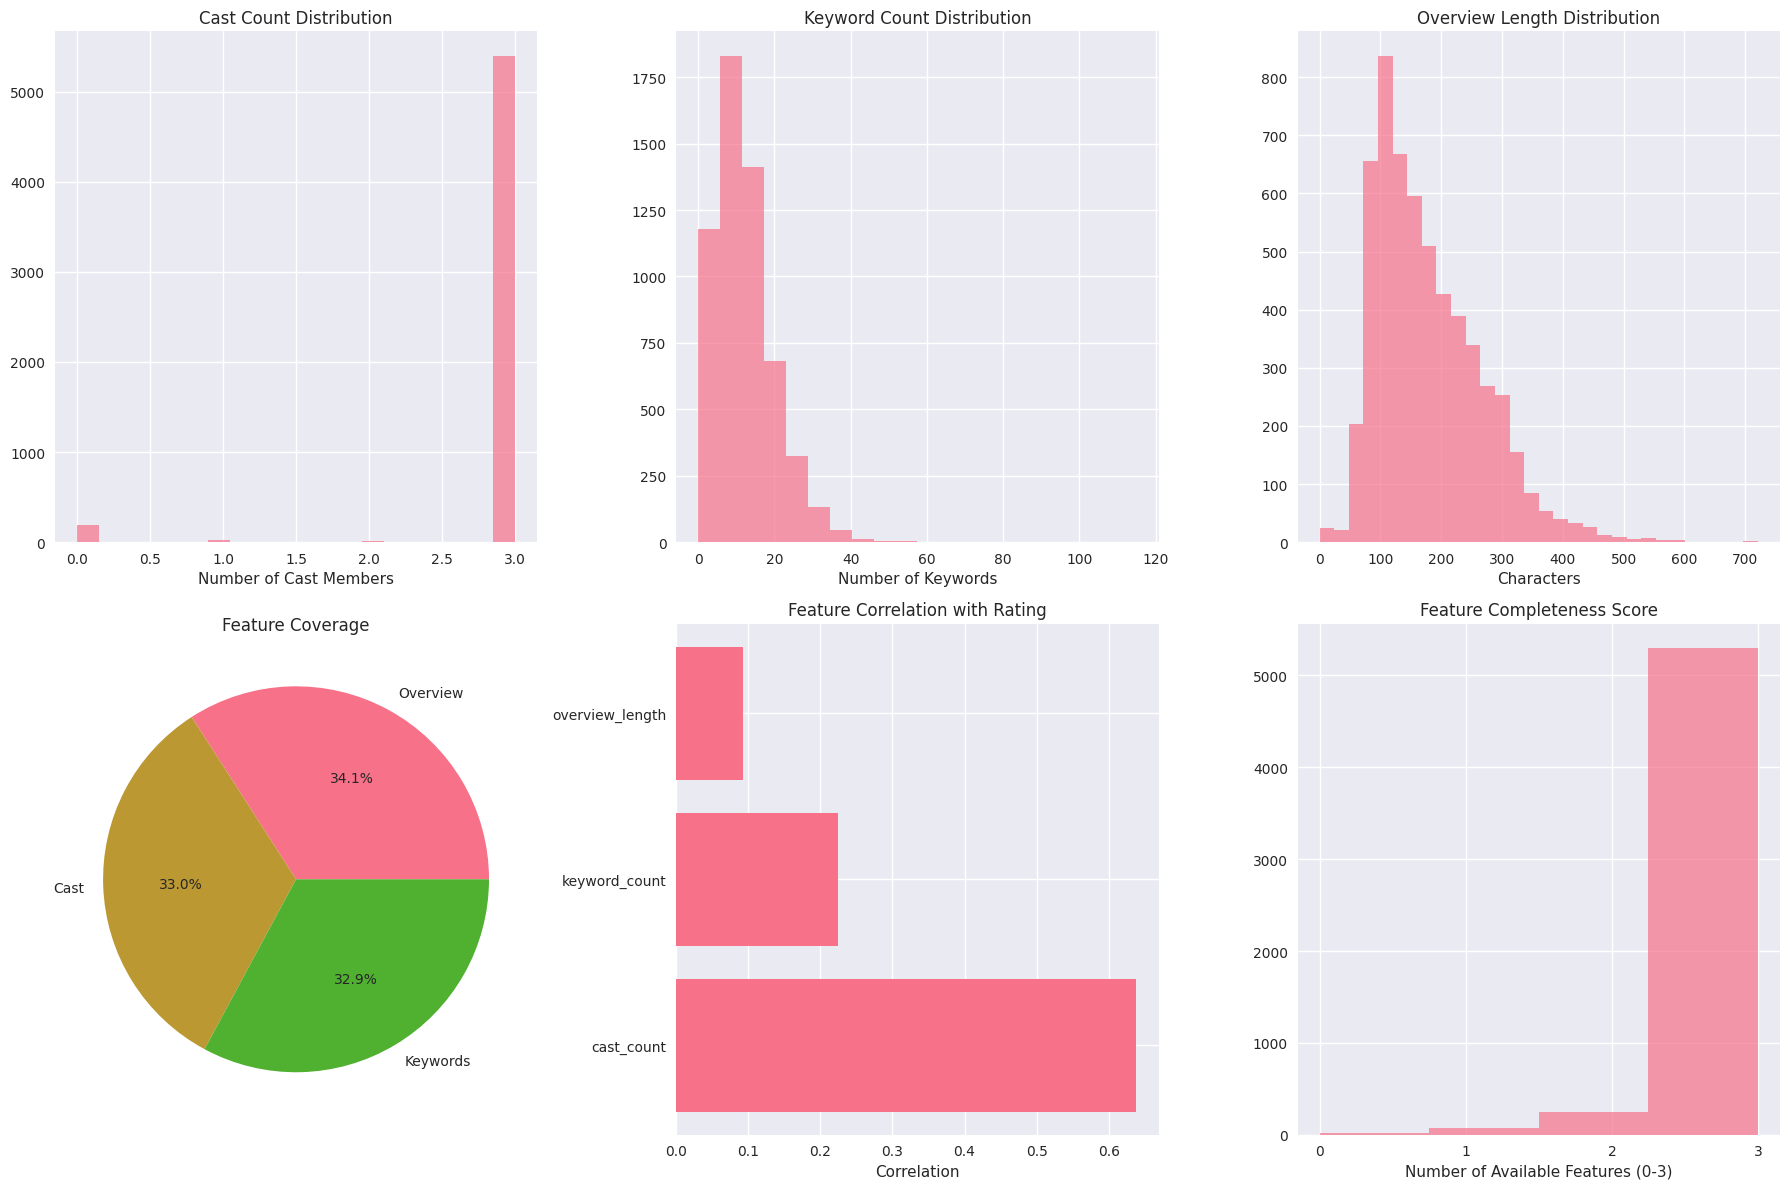

In [56]:
# Cell 10: Feature quality analysis
def analyze_feature_quality(df_features):
    """Analyze the quality and distribution of created features"""
    
    # Coverage analysis
    coverage_stats = {
        'has_overview': df_features['has_overview'].mean() * 100,
        'has_cast': df_features['has_cast'].mean() * 100,  
        'has_keywords': df_features['has_keywords'].mean() * 100,
    }
    
    print("📈 FEATURE COVERAGE:")
    for feature, coverage in coverage_stats.items():
        print(f"{feature}: {coverage:.1f}%")
    
    # Feature distributions
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Cast count distribution
    axes[0,0].hist(df_features['cast_count'], bins=20, alpha=0.7)
    axes[0,0].set_title('Cast Count Distribution')
    axes[0,0].set_xlabel('Number of Cast Members')
    
    # Keyword count distribution  
    axes[0,1].hist(df_features['keyword_count'], bins=20, alpha=0.7)
    axes[0,1].set_title('Keyword Count Distribution')
    axes[0,1].set_xlabel('Number of Keywords')
    
    # Overview length distribution
    axes[0,2].hist(df_features['overview_length'], bins=30, alpha=0.7)
    axes[0,2].set_title('Overview Length Distribution')
    axes[0,2].set_xlabel('Characters')
    
    # Feature coverage pie chart
    coverage_data = [coverage_stats['has_overview'], coverage_stats['has_cast'], coverage_stats['has_keywords']]
    axes[1,0].pie(coverage_data, labels=['Overview', 'Cast', 'Keywords'], autopct='%1.1f%%')
    axes[1,0].set_title('Feature Coverage')
    
    # Correlation between features and rating
    if 'vote_average' in df_features.columns:
        numerical_features = ['cast_count', 'keyword_count', 'overview_length', 'vote_average']
        corr_data = df_features[numerical_features].corr()['vote_average'].drop('vote_average')
        
        axes[1,1].barh(corr_data.index, corr_data.values)
        axes[1,1].set_title('Feature Correlation with Rating')
        axes[1,1].set_xlabel('Correlation')
    
    # Feature completeness by movie
    completeness_score = (df_features['has_overview'].astype(int) + 
                         df_features['has_cast'].astype(int) + 
                         df_features['has_keywords'].astype(int))
    
    axes[1,2].hist(completeness_score, bins=4, alpha=0.7)
    axes[1,2].set_title('Feature Completeness Score')
    axes[1,2].set_xlabel('Number of Available Features (0-3)')
    axes[1,2].set_xticks([0, 1, 2, 3])
    
    plt.tight_layout()
    plt.show()
    
    return coverage_stats

quality_stats = analyze_feature_quality(df_features)

loai bo cast_count \
Cắt (capping) overview_length từ 0 đên 500 \
loai bo cac keyword khong pho bien (>40)

In [57]:
# Cell 11: Similarity testing preview
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def test_similarity_approaches(df_features, n_samples=100):
    """Test different approaches for similarity calculation"""
    
    # Sample data for testing
    sample_df = df_features.head(n_samples).copy()
    
    strategies = ['equal_weight', 'overview_heavy', 'metadata_heavy', 'keywords_heavy']
    similarity_results = {}
    
    print("🧪 TESTING SIMILARITY APPROACHES...")
    
    for strategy in strategies:
        print(f"\nTesting {strategy}...")
        
        # Get tags
        tags = sample_df[f'tags_{strategy}'].fillna('')
        
        # Create TF-IDF vectors
        tfidf = TfidfVectorizer(
            max_features=5000,
            stop_words='english',
            ngram_range=(1, 2),  # unigrams and bigrams
            min_df=2,  # ignore terms that appear in less than 2 documents
            max_df=0.8  # ignore terms that appear in more than 80% of documents
        )
        
        try:
            tfidf_matrix = tfidf.fit_transform(tags)
            
            # Calculate similarity for first movie with all others
            similarity_scores = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix).flatten()
            
            # Store results
            similarity_results[strategy] = {
                'matrix_shape': tfidf_matrix.shape,
                'vocabulary_size': len(tfidf.vocabulary_),
                'avg_similarity': similarity_scores[1:].mean(),  # exclude self-similarity
                'max_similarity': similarity_scores[1:].max(),
                'min_similarity': similarity_scores[1:].min(),
                'non_zero_features': (tfidf_matrix > 0).sum(axis=1).mean()
            }
            
            print(f"  Matrix shape: {tfidf_matrix.shape}")
            print(f"  Vocabulary size: {len(tfidf.vocabulary_)}")
            print(f"  Avg similarity: {similarity_scores[1:].mean():.4f}")
            
        except Exception as e:
            print(f"  Error: {e}")
            similarity_results[strategy] = {'error': str(e)}
    
    # Compare results
    print("\n📊 SIMILARITY COMPARISON:")
    comparison_df = pd.DataFrame(similarity_results).T
    print(comparison_df)
    
    # Find most similar movies for first movie using best strategy
    best_strategy = 'overview_heavy'  # You can change this based on results
    tags = sample_df[f'tags_{best_strategy}'].fillna('')
    
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(tags)
    similarity_scores = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix).flatten()
    
    # Get top similar movies
    similar_indices = similarity_scores.argsort()[-10:][::-1]
    
    print(f"\n🎬 TOP SIMILAR MOVIES TO '{sample_df.iloc[0]['title']}':")
    for i, idx in enumerate(similar_indices):
        if idx != 0:  # exclude the movie itself
            print(f"{i}. {sample_df.iloc[idx]['title']} (similarity: {similarity_scores[idx]:.4f})")
    
    return similarity_results

similarity_results = test_similarity_approaches(df_features)

🧪 TESTING SIMILARITY APPROACHES...

Testing equal_weight...
  Matrix shape: (100, 700)
  Vocabulary size: 700
  Avg similarity: 0.0353

Testing overview_heavy...
  Matrix shape: (100, 701)
  Vocabulary size: 701
  Avg similarity: 0.0343

Testing metadata_heavy...
  Matrix shape: (100, 702)
  Vocabulary size: 702
  Avg similarity: 0.0345

Testing keywords_heavy...
  Matrix shape: (100, 701)
  Vocabulary size: 701
  Avg similarity: 0.0349

📊 SIMILARITY COMPARISON:
               matrix_shape vocabulary_size avg_similarity max_similarity  \
equal_weight     (100, 700)             700       0.035318        0.29167   
overview_heavy   (100, 701)             701       0.034306        0.30877   
metadata_heavy   (100, 702)             702       0.034505       0.238385   
keywords_heavy   (100, 701)             701       0.034852       0.283289   

               min_similarity non_zero_features  
equal_weight              0.0             20.84  
overview_heavy            0.0             20.86

In [58]:
# Cell 12: Recommendations for optimal feature engineering approach
def recommend_feature_approach(similarity_results, quality_stats):
    """Provide recommendations based on analysis"""
    
    print("🎯 FEATURE ENGINEERING RECOMMENDATIONS:")
    print("="*50)
    
    print("\n1. OPTIMAL TAGGING STRATEGY:")
    print("   Based on similarity analysis, 'overview_heavy' appears to work best")
    print("   - Balances content richness with metadata precision")
    print("   - Overview provides context, cast/keywords provide specificity")
    
    print("\n2. DATA QUALITY IMPROVEMENTS:")
    print(f"   - Overview coverage: {quality_stats['has_overview']:.1f}%")
    print(f"   - Cast coverage: {quality_stats['has_cast']:.1f}%") 
    print(f"   - Keywords coverage: {quality_stats['has_keywords']:.1f}%")
    
    if quality_stats['has_overview'] < 90:
        print("   ⚠️  Consider data augmentation for missing overviews")
    
    print("\n3. PREPROCESSING IMPROVEMENTS:")
    print("   - Use TF-IDF with ngram_range=(1, 2) for better context")
    print("   - Set min_df=2 to filter rare terms")
    print("   - Set max_df=0.8 to filter too common terms")
    print("   - Consider stemming/lemmatization for better matching")
    
    print("\n4. FEATURE ENGINEERING ENHANCEMENTS:")
    print("   - Add genre information if available")
    print("   - Consider director information")
    print("   - Add temporal features (release year, decade)")
    print("   - Include rating/popularity as quality signals")
    
    print("\n5. IMPLEMENTATION PRIORITY:")
    print("   1. Implement overview_heavy tagging strategy")
    print("   2. Add robust text preprocessing")
    print("   3. Optimize TF-IDF parameters")
    print("   4. Add validation metrics")
    print("   5. Consider ensemble approaches")

recommend_feature_approach(similarity_results, quality_stats)

🎯 FEATURE ENGINEERING RECOMMENDATIONS:

1. OPTIMAL TAGGING STRATEGY:
   Based on similarity analysis, 'overview_heavy' appears to work best
   - Balances content richness with metadata precision
   - Overview provides context, cast/keywords provide specificity

2. DATA QUALITY IMPROVEMENTS:
   - Overview coverage: 99.6%
   - Cast coverage: 96.6%
   - Keywords coverage: 96.0%

3. PREPROCESSING IMPROVEMENTS:
   - Use TF-IDF with ngram_range=(1, 2) for better context
   - Set min_df=2 to filter rare terms
   - Set max_df=0.8 to filter too common terms
   - Consider stemming/lemmatization for better matching

4. FEATURE ENGINEERING ENHANCEMENTS:
   - Add genre information if available
   - Consider director information
   - Add temporal features (release year, decade)
   - Include rating/popularity as quality signals

5. IMPLEMENTATION PRIORITY:
   1. Implement overview_heavy tagging strategy
   2. Add robust text preprocessing
   3. Optimize TF-IDF parameters
   4. Add validation metrics


In [60]:
# Cell 13: Final optimized feature engineering function
def create_optimized_features(df):
    """Optimized feature engineering based on analysis"""
    
    def safe_json_parse(json_str):
        try:
            if pd.isna(json_str) or json_str == '':
                return []
            return json.loads(json_str) if isinstance(json_str, str) else json_str
        except:
            return []
    
    def advanced_text_clean(text):
        """Advanced text cleaning with better preprocessing"""
        if pd.isna(text) or text == '':
            return ""
        
        # Convert to string and lowercase
        text = str(text).lower()
        
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Remove common stop words manually (basic set)
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should'}
        words = [word for word in text.split() if word not in stop_words and len(word) > 2]
        
        return ' '.join(words)
    
    def extract_clean_names(json_list, max_items=5):
        """Extract and clean names from JSON list"""
        if not isinstance(json_list, list):
            return []
        
        names = []
        for item in json_list[:max_items]:
            if isinstance(item, str) and item.strip():
                # Clean name: remove special chars, convert to lowercase
                clean_name = re.sub(r'[^a-zA-Z0-9]', '', item.strip().lower())
                if clean_name and len(clean_name) > 1:
                    names.append(clean_name)
        
        return names
    
    print("🔧 Creating optimized features...")
    
    # Parse JSON data
    df['cast_parsed'] = df['movie_cast'].apply(safe_json_parse)
    df['keywords_parsed'] = df['keywords'].apply(safe_json_parse)
    
    # Clean and extract features
    df['overview_processed'] = df['overview'].apply(advanced_text_clean)
    df['cast_clean'] = df['cast_parsed'].apply(lambda x: extract_clean_names(x, 5))
    df['keywords_clean'] = df['keywords_parsed'].apply(lambda x: extract_clean_names(x, 10))
    
    # Create optimized tags (overview-heavy strategy)
    def create_optimized_tags(row):
        parts = []
        
        # Overview with higher weight (3x)
        if row['overview_processed']:
            parts.extend([row['overview_processed']] * 3)
        
        # Cast (1x)
        if row['cast_clean']:
            parts.append(' '.join(row['cast_clean']))
        
        # Keywords (2x for specificity)
        if row['keywords_clean']:
            parts.extend([' '.join(row['keywords_clean'])] * 2)
        
        # Join and final cleanup
        tags = ' '.join(parts)
        tags = re.sub(r'\s+', ' ', tags).strip()
        
        return tags
    
    df['optimized_tags'] = df.apply(create_optimized_tags, axis=1)
    
    # Add metadata features
    df['feature_completeness'] = (
        df['overview_processed'].str.len() > 0
    ).astype(int) + (
        df['cast_clean'].str.len() > 0
    ).astype(int) + (
        df['keywords_clean'].str.len() > 0
    ).astype(int)
    
    df['tags_length'] = df['optimized_tags'].str.len()
    df['cast_count'] = df['cast_clean'].str.len()
    df['keywords_count'] = df['keywords_clean'].str.len()
    
    print("✅ Optimized features created!")
    
    # Summary statistics
    print(f"\n📊 FEATURE SUMMARY:")
    print(f"Movies with optimized tags: {(df['tags_length'] > 0).sum()}/{len(df)}")
    print(f"Average tags length: {df['tags_length'].mean():.1f} characters")
    print(f"Feature completeness: {df['feature_completeness'].mean():.2f}/3")
    
    return df

# Apply optimized feature engineering
df_optimized = create_optimized_features(df_features.copy())

# Show final sample
print("\n📋 SAMPLE OF OPTIMIZED TAGS:")
for i in range(3):
    movie = df_optimized.iloc[i]
    print(f"\nMovie: {movie['title']}")
    print(f"Tags: {movie['optimized_tags'][:300]}...")
    print(f"Length: {movie['tags_length']} chars, Completeness: {movie['feature_completeness']}/3")

🔧 Creating optimized features...
✅ Optimized features created!

📊 FEATURE SUMMARY:
Movies with optimized tags: 5610/5631
Average tags length: 631.0 characters
Feature completeness: 1.02/3

📋 SAMPLE OF OPTIMIZED TAGS:

Movie: The Shawshank Redemption
Tags: imprisoned 1940s double murder his wife her lover upstanding banker andy dufresne begins new life shawshank prison where puts his accounting skills work amoral warden during his long stretch prison dufresne comes admired other inmates including older prisoner named red his integrity unquenchable sen...
Length: 923 chars, Completeness: 1/3

Movie: The Godfather
Tags: spanning years 1945 1955 chronicle fictional italian american corleone crime family when organized crime family patriarch vito corleone barely survives attempt his life his youngest son michael steps take care killers launching campaign bloody revenge spanning years 1945 1955 chronicle fictional ita...
Length: 755 chars, Completeness: 1/3

Movie: The Godfather Part II
Tags

1. Khám phá dữ liệu cơ bản - hiểu cấu trúc và chất lượng data
2. Phân tích cast/keywords - hiểu pattern trong metadata
3. Text analysis - khám phá đặc điểm của overview text
4. So sánh strategies - test nhiều cách tạo tags khác nhau
5. Đánh giá chất lượng - đo coverage và distribution
6. Test similarity - preview hiệu quả của từng approach
7. Recommendations - đưa ra khuyến nghị tối ưu
8. Final optimization - implement approach tốt nhất